# **Soni - do:  Generating Music with Machine Learning**


#### Author: Sonia Cobo
#### Date: July 2021

<table align="center"> 
<tr><td width="800"><img src="../resources/title.jpeg" style="width:10;height:10"></td> 
<td style="image-align:center"> 
</td></tr> 
</table>

### Music is associated with emotions, experiences and creativity, all o them considered human's qualities. 

### Though this project doesn't have a hypothesis per se it was done to prove that technology has advanced to the point where a machine, that cannot experience these feelings, can generate music.

### Tis project will explain and show how music has been generated using a differente types of neural networks in Python using the Keras library.

# Data

### Music files have been imported to Python in MIDI format. MIDI (Musical Instrument Digital Interface) is a technical standard that describes a communications protocol, digital interface, and electrical connectors that connect a wide variety of electronic musical instruments and computers. They don't contain actual audio data and are small in size. They explain what notes are played, when they're played, and how long or loud each note should be.

### To optimise results only MIDI files consisting of a single instrument were chosen. In this case, the chosen instrument is piano and the type of songs is classical. 

### These songs have been obtained from the following datasets: http://www.piano-midi.de/ and https://www.mfiles.co.uk/classical-midi.htm
### As guidance for the project the following example was considered: 'How to Generate Music using a LSTM Neural Network in Keras' by Sigurður Skúli.


## Import all libraries

In [292]:
# data manipulation
import numpy as np
import pandas as pd 
from collections import Counter


# manipulate midi files
import glob
from music21 import *
import pygame

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# route files
import os
import sys

# ml model
import pickle

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import Flatten

# my libraries
import utils.mining_data_tb as md
from utils.folders_tb import read_json
#import utils.visualization_tb as vis
from utils.sql_tb import MySQL

import warnings
warnings.filterwarnings("ignore")


## Paths

In [293]:
# The route of this file is added to the sys path to be able to import/export functions
sep = os.sep
def route (steps):
    """
    This function appends the route of the file to the sys path
    to be able to import files from/to other foders within the EDA project folder.
    """
    route = os.getcwd()
    for i in range(steps):
        route = os.path.dirname(route)
    sys.path.append(route)
    return route

In [294]:
# path to raw data
path = route(1) + sep + "data" + sep + "raw_data" + sep
# path to data in the right key
path_1 = route(1) + sep + "data" + sep + "converted_data" + sep
# path to compiled notes list
path_2 = route(1) + sep + "data" + sep + "notes" + sep
# path to generated models
path_3 = route(1) + sep + "models" + sep
# path to generated midi files
path_4 = route(1) + sep + "reports" + sep
# path to output information
path_5 = route(1) + sep + "data" + sep + "output" + sep

## Midi file exploration

### The Python library 'Music21' has been used to read and manipulate MIDI files. This library has the necessary classes to allow us to read music. 

### To start working with MIDI files these need to be converted to Score objects, which are a subclass for handling multi-part music. Once this is done it is possible to use the library build-in classes to view the file information. Knowing all the file components it is possible to select the useful ones for our prediction. The main components to generate new melodies, and those considered in this project, are notes, rests and chords. To make prediccions more accurate more components could be considered, such us the time signature or offsets.

### Note objects contain information about the pitch, octave, and offset of the note. Pitch refers to the frequency of the sound, or how high or low it is and is represented with the letters [A, B, C, D, E, F, G] or [Do, Re, Mi, Fa, Sol, La, Si] in Spanish. Octave refers to which set of pitches you use on a piano. Offset refers to where the note is located in the piece.

### Rests are the silences in the piece.

### Chord objects are a set of notes that are played at the same time.

### The below figure represents pitches and octaves in a keyboard for reference.

<table align="center"> 
<tr><td width="10000"><img src="../resources/pitch_and_octaves.png" style="width:14000;height:1500"></td> 
<td style="image-align:center"> 
</td></tr> 
</table>

In [295]:
# All information from the midi file (i.e. notes, pitch, chord, time signature, etc) is contained within the component list

def info_midi (path, filename):
    """
    It returns all midi file information given its path and filename

    """
    # Convert to Score object
    file = converter.parse(path + filename)
    components = []
    # read file information
    for element in file.recurse():  
        components.append(element)
    return components

components = info_midi(path, "alb_esp1.mid")
components[:15]

[<music21.stream.Part 0x131d0d1e2c8>,
 <music21.instrument.Piano 'Piano right: Piano right'>,
 <music21.instrument.Piano 'Piano'>,
 <music21.tempo.MetronomeMark moderate Quarter=93.43>,
 <music21.key.Key of F major>,
 <music21.meter.TimeSignature 3/4>,
 <music21.stream.Voice 0x131bcf9c9c8>,
 <music21.note.Rest rest>,
 <music21.note.Note A>,
 <music21.note.Note E>,
 <music21.note.Note D>,
 <music21.note.Note D>,
 <music21.note.Note C>,
 <music21.note.Note D>,
 <music21.note.Note E>]

### The component list also shows the piece key, which is the group of pitches, or scale, that forms the basis of a music composition. Each piece has its own key signature but using the same, in this case C major / A minor assists the model to not go off key. The below function read each piece key and transpose it to C major / A minor.

In [128]:
md.transpose_key(path, path_1)

In [ ]:
#  probar que pasa si le meto cualquier midi, de varios instrumentos, etc
# data augmentation = min_notes_freq

### The project considers the below amount of data. However, it is possible to make predictions with only one piece and much more if wanted.


In [296]:
print(f"Total number of songs: {len(os.listdir(path_1))}")
print(f"Total number of notes: {len(all_notes)}")
print(f"Total number of unique notes: {len(set(all_notes))}")

Total number of songs: 342
Total number of notes: 696938
Total number of unique notes: 589


## EDA

### It is now understood all information provided by the MIDI file. This relevant information needs now to be encoded and saved into an array to feed the neural network. This project will only considered the notes (which relates to pitches), rests and chords.

### The pitch of every note object is appended to a list using string notation since the most significant parts of the note can be recreated using the string notation of the pitch. Chords are enconded using the id of every note together into a single string, with each note being separated by a dot.

In [297]:
# Each midi file contains notes, rests and chords. These three properties will be the input and output of the LSTM network so 
# they need to be taken out from all midi files. 

def get_notes_per_song(path, filename, save_path, save_name):
    """
    This function extracts all the notes, rests and chords from one midi file
    and saves it in a list in the converted_data folder.

    Param: Path of the midi file, its filename (str), path where the list will be saved and its name.
    """
    components = info_midi(path, filename)
    note_list = []
    
    for element in components:
        # note pitches are extracted
        if isinstance(element, note.Note):
            note_list.append(str(element.pitch))
        # chords are extracted
        elif isinstance(element, chord.Chord):
            note_list.append(".".join(str(n) for n in element.normalOrder))    
        # rests are extracted
        elif isinstance(element, note.Rest):
            note_list.append("REST")    

    # data cleaning
    note_list = [elem.replace("-", "") for elem in note_list]
    # save list with all componenets extracted
    with open(save_path + save_name, "wb") as filepath:
        pickle.dump(note_list, filepath)
    
    return note_list

In [299]:
one_song = get_notes_per_song(path_1, "C_alb_esp1.mid", path_2, "one_notes")

print(f" This list contains a total number of {len(one_song)} notes and chords, being {len(set(one_song))} of them unique.")

 This list contains a total number of 687 notes and chords, being 46 of them unique.


### It is possible to encode a list of songs at the same time rather than going one song at a time:

In [121]:
def get_all_notes(path, save_name, save_path):
    """
    This function extracts all the notes, rests and chords from all midi files 
    and saves it in a list in the converted_data folder.

    Param: Path of the midi file, path where the list will be saved and its name.
    """
    all_notes = []
    list_path = os.listdir(path)
    for filename in list_path:
        output = get_notes_per_song(path, filename, save_path, save_name)
        all_notes += output
        
    # data cleaning
    all_notes = [elem.replace("-", "") for elem in all_notes]

    return all_notes

In [300]:
all_notes = get_all_notes(path = path_1, save_path = path_2, save_name = "all_notes")

print(f" This list contains a total number of {len(all_notes)} notes and chords, being {len(set(all_notes))} unique.")

 This list contains a total number of 696938 notes and chords, being 589 unique.


### To avoid having to read and save all pieces each time the below function returns the previously coded and saved list containing the extracted notes from the pieces.

In [124]:
# Load notes and chords previously separated
def load_notes (path, filename):
    """
    Load the note list containing pitches, rests and chords.
    
    Param: Path of the saved note list, and its name as string
    """
    with open(path + filename, "rb") as f:
        loaded_notes = pickle.load(f)
        return loaded_notes

### The model will be first trained with a small proportion of the pieces to expedite time. Once the model is tunned properly all pieces will be passed to improve its predictions.

In [ ]:
#load_chopin = load_notes(path_2, "notes_chopin")
one_song = load_notes(path_2, "one_notes")

### To be able to share the input data a dataframe with all pieces and their notes has been created.

In [301]:
# generate dataframe

def create_dataframe(path, save_path, save_name):
    """
    Create a dataframe and a list with all pieces title and the notes, rests and chrods included in the piece. 

    Param: Path of the midi file, filename (str), path where the list will be saved and its name.
    """
    list_path = os.listdir(path)
    piece_list = []
    notes = []
    # extracting all songs from the list
    for elem in list_path:
        output = get_notes_per_song(path, elem, save_path, save_name)
        piece_list.append(elem[2:-4])
        notes.append(output)

    # create dataframe
    df = pd.DataFrame.from_dict({"Piece":piece_list, "Notes":notes}, orient="index")
    df = df.transpose()

    return df

In [302]:
df_music = create_dataframe(path= path_1, save_path = path_2, save_name = "all_notes")

In [303]:
df_music

,Piece,Notes
0,alb_esp1,"[REST, E5, B5, A5, A5, G5, A5, B5, C6, D6, B5,..."
1,alb_esp2,"[REST, G3, 0.4.7, REST, G3, 0.4.7, 7.0, E4, F4..."
2,alb_esp3,"[E5, REST, G#5, REST, B5, REST, A5, A5, F5, RE..."
3,alb_esp4,"[A5, REST, E5, REST, F5, REST, A5, REST, G#5, ..."
4,alb_esp5,"[REST, 0.4, 11.2, 2.5, 11.2, 0.4, 9.0, 5.9, 4...."
...,...,...
337,waldstein_1,"[REST, 0.4, REST, 0.4, REST, 0.4, REST, 0.4, R..."
338,waldstein_2,"[REST, C3, REST, A3, REST, A3, A3, REST, 4.8, ..."
339,waldstein_3,"[REST, A5, G5, A5, G5, A5, G5, A5, G5, A5, G5,..."
340,waltz-op18-grande-brillante,"[D5, D5, REST, D5, REST, D5, D5, REST, D5, RES..."


In [304]:
# Save cleaned data in the appropriate folder, in this case it is the folder 'data'
def save_dataframe(path, dataframe, dataframe_name):
    """
    Create a cvs file from a dataframe.
    Param: Path to save the dataframe, dataframe to save and its name as string
    """
    dataframe.reset_index(inplace = True)
    if "index" in dataframe.columns:
        dataframe.drop(columns = "index", inplace = True)
    dataframe.to_csv(path + dataframe_name + ".csv", index=False)
    return "Your file has been saved"

### To avoid having to create and load the dataframe each time, it can be saved and read it back for its simple use.

In [305]:
save_dataframe(path_5, df_music, "df_music")

'Your file has been saved'

In [62]:
md.read_dataframe(path_5, "df_music")

## Visualization

In [ ]:
# Represent all different notes in one song-------------------
# ---------------------in streamlit let user choose the song, o hacer las gráficas en streamlit para que sean interactivas


In [306]:
def plot_one_song(data_notes, data_piece, number):
    """
    Plot all different notes and rests contained in one song
    """
    clean_column = data_notes[number]
    contador = 0
    while contador <= len(clean_column):
        contador +=1
        for elem in clean_column:
            if elem.count(".") >= 1 or elem == "REST" or elem.isdigit() == True:
                clean_column.remove(elem)

    # notes are organised by occurence
    d = Counter(clean_column)
    data = {"Note":list(d.keys()), "count": list(d.values())}
    df = pd.DataFrame(data, index=range(len(data["Note"])))
    df = df.sort_values("count", ascending=False)

    fig, ax = plt.subplots(figsize=(8, 4))
    
    piece_title= data_piece[number]

    chart = sns.barplot(df["Note"], df["count"] ,color = "green")

    for p in chart.patches:
        chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
            textcoords='offset points')

    ax.set_title(f"Note distribution per piece - Piece title: {piece_title}")
    ax.set_xlabel("Notes")
    ax.set_ylabel("Ocurrence")
    plt.xticks(rotation = 90)

    plt.show()
    

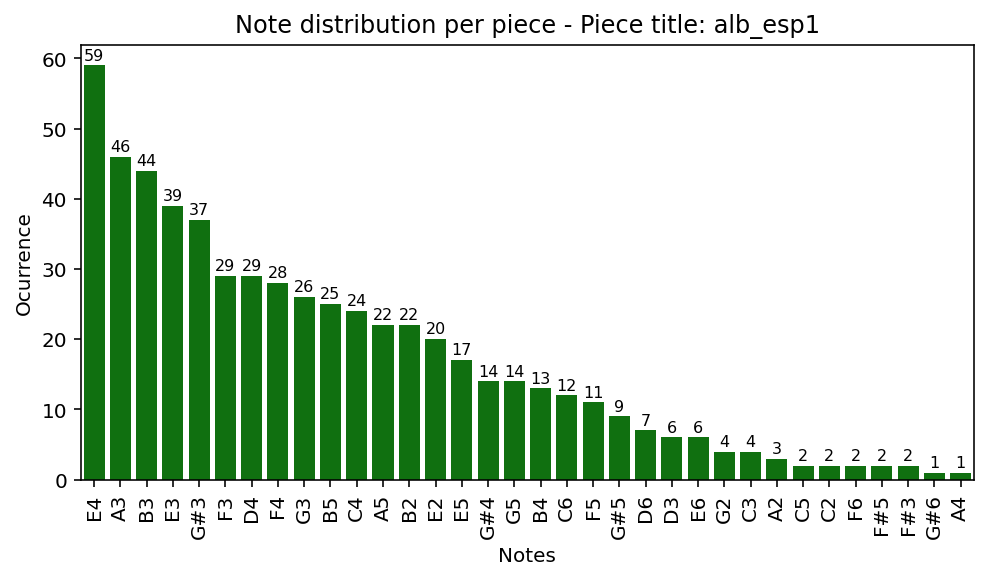

In [307]:
plot_one_song(df_music["Notes"], df_music["Piece"], 0)

### It is also possible to compare the note distribution considering all analysed pieces.

In [290]:
# Represent all different notes in all songs

def plot_all_songs(notes):
    """
    Plot all different notes contained in all pieces
    """
    fig, ax = plt.subplots(figsize=(8, 4))

    # copy of note_list to not delete info for the model
    clean_list = notes[::]
    contador = 0
    while contador <= len(clean_list):
        contador +=1
        for elem in clean_list:
            # remove chords and rests
            if elem.count(".") >= 1 or elem == "REST" or elem.isdigit() == True:
                clean_list.remove(elem)

    # notes are organised by occurence
    d = Counter(clean_list)
    data = {"Note":list(d.keys()), "count": list(d.values())}
    df = pd.DataFrame(data, index=range(len(data["Note"])))
    df = df.sort_values("count", ascending=False)

    fig, ax = plt.subplots(figsize=(8, 4))
    
    chart = sns.barplot(df["Note"], df["count"] ,color = "green")


    #chart = sns.barplot(clean_list, color = "green")

    for p in chart.patches:
        chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
            textcoords='offset points')

    ax.set_title("Note distribution in all pieces")
    ax.set_xlabel("Notes")
    ax.set_ylabel("Ocurrence")
    plt.xticks(rotation = 90)

    plt.show()

In [308]:
# plot_all_songs(all_notes) ------------------------------nunca acaba de cargar. Dejarlo toda la noche

## Pre-processing

### Now that all notes, rests and chords are in a list, these will be transformed from categorical data to integer-based numerical data. It is necessary to create input sequences for the network and their respective outputs. The output for each input sequence will be the first note or chord that comes after the sequence of notes in the input sequence in our list of notes. 

### The length of each sequence will be 100 notes for now. This means that to predict the next note in the sequence the network has the previous 100 notes to help make the prediction.

### If a long list is passed to the neural network the computer does not have the required memory to carry out all operations. To solve this issue without having to reduce the sequence length or another parameter it is possible to reduce the number of notes/chords given to the newtork based on its occurence in the piece. If a note does not appear more than the specified occurence value then it is removed from the list.

### If this solution does not resolve the memory issue, and other parameters don't want to be changed, less songs will need to be taken all at once.

In [309]:
def prepare_sequences(notes, min_note_occurence, sequence_length, step):
    """ 
    This function creates the input and output sequences used by the neural network.
    It returns the x and y of the model.

    Param: 
        Note: List containing all notes, rests and chords
        Min_note_ocurrence: Note occurence (int)
        Sequence_length: Lenght of notes given to the model to help predict the next
        Step: Step (int) between one input sequence and the next one
    """
    # get all pitchnames
    pitchnames = sorted(set(notes))

    # Calculate note occurence
    note_occ = {}
    for elem in notes:
        note_occ[elem] = note_occ.get(elem, 0) + 1

    ignored_notes = set()
    for k, v in note_occ.items():
        if note_occ[k] < min_note_occurence:
            ignored_notes.add(k)
    
    # create a dictionary to convert pitches (strings) to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))  # rests are included  

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, step): 
        # remove ignored notes from the note list   
        if len(set(notes[i: i+ sequence_length + 1]).intersection(ignored_notes)) == 0:
            network_input.append(notes[i:i + sequence_length])
            network_output.append(notes[i + sequence_length])
    # array of zeros
    x = np.zeros((len(network_input), sequence_length, len(pitchnames)))
    y = np.zeros((len(network_input), len(pitchnames)))
    # exchange note values for their integer-code
    for i, sequence in enumerate(network_input):
        for j, note in enumerate(sequence):
            x[i, j, note_to_int[note]] = 1
        y[i, note_to_int[network_output[i]]] = 1

    return x, y

### To test the model the first trial considered only one piece. As they have been arranged alphabetically this piece was Prélude (1890) by Albéniz.	


In [310]:
x, y = prepare_sequences(notes=one_song, min_note_occurence=1, sequence_length=100, step=3)  # dif sequence_length para comparar modelos

## Neural Network

### The baseline model is a recurrent network consisting of a LSTM layer which takes a sequence as an input and can return a matrix.

### This model consists of one LSTM layers, one Dense layers and one activation layer. The network structure can be modified to improve the quality of the predictions. The Dense layer is a fully connected neural network layer where each input node is connected to each output node, and the Activation layer determines what activation function will be used to calculate the output of a node.


In [311]:
# baseline model
def lstm_model (num_units, num_dense, input_shape):
    """
    Builds and compiles a simple RNN model
    Param:
              num_units: Number of units of a the simple RNN layer
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              input_shape: input_shape
    """
    model = Sequential()
    model.add(LSTM(num_units, input_shape=input_shape))
    model.add(Dense(num_dense))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["RootMeanSquaredError", "Accuracy"])

    return model

In [312]:
model = lstm_model(num_units=x.shape[0], num_dense=x.shape[2], input_shape=(x.shape[1],x.shape[2]))

In [313]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 196)               190512    
_________________________________________________________________
dense (Dense)                (None, 46)                9062      
_________________________________________________________________
activation (Activation)      (None, 46)                0         
Total params: 199,574
Trainable params: 199,574
Non-trainable params: 0
_________________________________________________________________


In [86]:
# early stopping if the model is too big

109


### Train the model considering only 1 epoch (iteration). This variable can be adjusted to improve the quality of predictions. Future trials will increase this value to compare model results. It is also possible to include batches to avoid giving all data at the same time.

In [314]:
model.fit(x, y, epochs=1)

7/7 [==============================] - 13s 67ms/step - loss: 3.7502 - root_mean_squared_error: 0.1461 - accuracy: 0.0000e+00


### The network loss, accuracy and root mean squared error are inserted into a dataframe to be able to compare different models.

In [316]:
result_errors = model.evaluate(x, y, verbose=1)

7/7 [==============================] - 1s 19ms/step - loss: 3.2412 - root_mean_squared_error: 0.1437 - accuracy: 0.0000e+00


In [317]:
# Dataframe with model information
params = ["loss=categorical_crossentropy, optimizer=rmsprop, 20 epoch"]

df_error = pd.DataFrame({"model": "LSTM", "parameters": params, "loss": result_errors[0], "rmse": result_errors[1], "accuracy": result_errors[2]}, index=[1])
df_error

# ver si puedo automatizar los parametros

,model,parameters,loss,rmse,accuracy
1,LSTM,"loss=categorical_crossentropy, optimizer=rmspr...",3.241231,0.143739,0.0


### Save model for its possible future use

In [319]:
# save model
model.save(path_3 + "baseline_lstm_1epoch_1song_1.h5")

In [320]:
# load model
model = tf.keras.models.load_model(path_3 + "baseline_lstm_1epoch_1song_1.h5")

In [321]:
# clean garbage
import gc
gc.collect()

10138

## Predictions

### Once the model has been trained, some post-processing operations are required to be able to make predictions. 

### To make a prediction a full list of note sequences is chosen using a random index in the original list. This allows to re-run the generation code without changing anything and get different results every time. Contrary to the first process done, a mapping function here will decode the output of the network. This function will transform from numerical data (integers) to categorical data (notes).

### For each predicted note that we want to generate we have to submit a sequence to the network. 

### A sequence to the network is fed for each generated note. The first submitted sequence is the sequence of notes at the starting index. A sliding-window method is applied and every subsequent sequence is the output of the previous iteration at the end of the sequence without the first note. To determine the most likely prediction from the output the index of the highest value is considered and then decoded to represent its note, rest or chord.

### The amount of generated notes can be chosen, for reference 500 notes is roughly two minutes of music.

### To try to improve predictions differente temperatures can be used. Temperature is a hyperparameter of neural networks used to control the randomness of predictions by scaling the logits before applying softmax. 

### Using a higher temperature value produces a softer probability distribution over the classes, and makes the neural network less conservative in its samples, resulting in more diversity and also more mistakes.

In [322]:
# Temperature to control prediction randomness

def sample(preds, temperature=1.0):
    """
    Helper function to sample an index from a probability array

    """
    # probability distribution 
    preds = np.asarray(preds).astype("float64")
    # convert to the correct numpy array type
    preds = np.log(preds) / temperature
    # scaling
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [323]:
def generate_notes(notes, model, temperature=1.0):
    """ 
    Generate notes from the neural network based on a sequence of notes

    Param: 
        Notes: List containing notes
        Model: Neural network
        Temperature: int to control prediction randomness 
    """
    # pick a random sequence from the input as a starting point for the prediction
    start = np.random.randint(0, len(notes)-100-1)

    pitchnames = sorted(set(notes))
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames)) 
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    
    pattern = notes[start: (start+100)] 
    prediction_output = []
    patterns = []

    # 500 notes equals to roughly two minutes of music
    for note_index in range(100):
        prediction_input = np.zeros((1, 100, len(pitchnames)))
        for j, note in enumerate(pattern):
            prediction_input[0, j, note_to_int[note]] = 1.0
        preds = model.predict(prediction_input, verbose=0)[0] 
            
        next_index = sample(preds, temperature=temperature)
        next_note = int_to_note[next_index]

        pattern = pattern[1:]
        pattern.append(next_note)

        prediction_output.append(next_note)

        patterns.append(next_index)

    return prediction_output, patterns

In [324]:
prediction_output, patterns = generate_notes(notes=one_song, model=model, temperature=1.0)
print(prediction_output)

['D4', 'E5', 'C2', 'B2', '5.11', 'A3', 'D3', 'B2', 'E3', 'D6', 'D3', 'G#3', 'G#3', 'B2', 'REST', 'A5', 'E3', 'A4', '11.0', 'B4', 'G3', 'G2', 'B2', 'B3', 'A3', 'D4', 'F5', 'C6', 'G#3', 'REST', 'E3', '0.2', 'A4', 'B2', 'B2', 'E3', 'F4', 'F3', 'G#6', 'E5', 'E6', 'E3', 'E4', 'C2', '8.11', 'E3', '7.9', 'A4', 'B3', '11.0', '11.0', 'C2', 'G#5', 'E3', 'E3', 'E3', 'E3', 'E3', 'E3', 'REST', 'D3', 'B2', 'C2', 'C4', 'D6', 'E5', 'E3', 'E3', 'D4', 'F3', 'B2', 'B2', 'C2', 'A3', 'F3', 'E5', 'G#5', 'E3', 'REST', 'B2', 'E4', 'E3', 'E3', 'E5', 'G3', '11.0', 'E3', 'REST', 'B2', 'E4', 'E3', 'F3', 'G#3', 'F#3', 'E3', '11.4', 'A5', 'F#3', 'G#4', 'E5']


## Post-Processing

### Now that an array full of predicted notes have been generated it is time to decode it. Its elements can be notes, rests or chords.

### If the patter is a note or a rest it will be decoded using the note and rest object respectively from the librery Music21. It it is a chord, it will be split into an array of notes. Each note will be converted using the note object and then compiled into the chord object considering those notes.

### At the end of this decodification a MIDI file is created with these objects to be able to listen to the model predictions.

In [325]:
def create_midi(prediction_output, path):
    """ 
    This functions converts model predictions to midi files
    
    Param: Decodified prediction output (list) from the model and path to save the midi file.    
    """
    
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif ("REST" in pattern):
            new_rest = note.Rest(pattern)
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)   
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    # save generated midi file
    midi_stream.write("midi", fp= path + "baseline_lstm_1epoch_1song_1.mid")   # first output 01/07/2021

    return midi_stream

In [326]:
create_midi = create_midi(prediction_output, path_4)

### The below function allows to play the generated MIDI files without leaving the notebook

In [327]:
def play_music(music_file):
    """
    Play music given a midi file path
    """
    #import music21
    try:
        # allow to stop the piece 
        pygame.mixer.init()
        clock = pygame.time.Clock() 
        pygame.mixer.music.load(music_file)
        pygame.mixer.music.play()
        while pygame.mixer.music.get_busy():
            # check if playback has finished
            clock.tick(10)

        freq = 44100    # audio CD quality
        bitsize = -16   # unsigned 16 bit
        channels = 2    # 1 is mono, 2 is stereo
        buffer = 1024    # number of samples
        pygame.mixer.init(freq, bitsize, channels, buffer)

    except KeyboardInterrupt:
        while True:
            action = input('Enter Q to Quit, Enter to Skip.').lower()
            if action == 'q':
                pygame.mixer.music.fadeout(1000)
                pygame.mixer.music.stop()
            else:
                break

### The first created MIDI file was just one note repeated over 2 minute time.

In [330]:
play_music(path_4 + "1st_baseline_lstm_10epoch_1song_1.mid")

### After adjusting the pre and post processes, as well as the neural network more interesting melodies were generated.

In [328]:
# Plays music when the cell is executed 

# Baseline LSTM model, 1 epoch considering only one piece
play_music(path_4 + "baseline_lstm_1epoch_1song_1.mid")

## Conclusion

### This one week project has proved that deep learning is capable of generating new melodies. Though their results are far from perfect it is still impressive what a shallow neural network and a simple GAN network are capable to do. 

## Future steps

### - Time signature the same to 4/4 would have added more consistancy to the input and probably improve the model predictions
### - Keep the length of all pieces the same
### - Try more parameters and layers to both networks. However, deeper network also required a more powerful computer.
### - Play around with number of epoch and batches to optimised results
### - Train the model with different instruments